In [ ]:
#!pip install pyparsing

# fourFn

In [ ]:
from pyparsing import (
    Literal,
    Word,
    Group,
    Forward,
    alphas,
    alphanums,
    Regex,
    ParseException,
    CaselessKeyword,
    Suppress,
    delimitedList,
)
import math
import operator

In [ ]:
exprStack = []

In [ ]:
def push_first(toks):
    exprStack.append(toks[0])

In [ ]:
def push_unary_minus(toks):
    for t in toks:
        if t == "-":
            exprStack.append("unary -")
        else:
            break

In [ ]:
bnf = None

In [ ]:
def BNF():
    """
    expop   :: '^'
    multop  :: '*' | '/'
    addop   :: '+' | '-'
    integer :: ['+' | '-'] '0'..'9'+
    atom    :: PI | E | real | fn '(' expr ')' | '(' expr ')'
    factor  :: atom [ expop factor ]*
    term    :: factor [ multop factor ]*
    expr    :: term [ addop term ]*
    """
    global bnf
    if not bnf:
        # use CaselessKeyword for e and pi, to avoid accidentally matching
        # functions that start with 'e' or 'pi' (such as 'exp'); Keyword
        # and CaselessKeyword only match whole words
        e = CaselessKeyword("E")
        pi = CaselessKeyword("PI")
        # fnumber = Combine(Word("+-"+nums, nums) +
        #                    Optional("." + Optional(Word(nums))) +
        #                    Optional(e + Word("+-"+nums, nums)))
        # or use provided pyparsing_common.number, but convert back to str:
        # fnumber = ppc.number().addParseAction(lambda t: str(t[0]))
        fnumber = Regex(r"[+-]?\d+(?:\.\d*)?(?:[eE][+-]?\d+)?")
        ident = Word(alphas, alphanums + "_$")

        plus, minus, mult, div = map(Literal, "+-*/")
        lpar, rpar = map(Suppress, "()")
        addop = plus | minus
        multop = mult | div
        expop = Literal("^")

        expr = Forward()
        expr_list = delimitedList(Group(expr))
        # add parse action that replaces the function identifier with a (name, number of args) tuple
        def insert_fn_argcount_tuple(t):
            fn = t.pop(0)
            num_args = len(t[0])
            t.insert(0, (fn, num_args))

        fn_call = (ident + lpar - Group(expr_list) + rpar).setParseAction(
            insert_fn_argcount_tuple
        )
        atom = (
            addop[...]
            + (
                (fn_call | pi | e | fnumber | ident).setParseAction(push_first)
                | Group(lpar + expr + rpar)
            )
        ).setParseAction(push_unary_minus)

        # by defining exponentiation as "atom [ ^ factor ]..." instead of "atom [ ^ atom ]...", we get right-to-left
        # exponents, instead of left-to-right that is, 2^3^2 = 2^(3^2), not (2^3)^2.
        factor = Forward()
        factor <<= atom + (expop + factor).setParseAction(push_first)[...]
        term = factor + (multop + factor).setParseAction(push_first)[...]
        expr <<= term + (addop + term).setParseAction(push_first)[...]
        bnf = expr
    return bnf

In [ ]:
# map operator symbols to corresponding arithmetic operations
epsilon = 1e-12
opn = {
    "+": operator.add,
    "-": operator.sub,
    "*": operator.mul,
    "/": operator.truediv,
    "^": operator.pow,
}

fn = {
    "sin": math.sin,
    "cos": math.cos,
    "tan": math.tan,
    "exp": math.exp,
    "abs": abs,
    "trunc": int,
    "round": round,
    "sgn": lambda a: -1 if a < -epsilon else 1 if a > epsilon else 0,
    # functionsl with multiple arguments
    "multiply": lambda a, b: a * b,
    "hypot": math.hypot,
    # functions with a variable number of arguments
    "all": lambda *a: all(a),
    "Circle": lambda x,y,r: f"center=({x},{y}),radius={r}"
}

In [ ]:
def evaluate_stack(s):
    op, num_args = s.pop(), 0
    if isinstance(op, tuple):
        op, num_args = op
    if op == "unary -":
        return -evaluate_stack(s)
    if op in "+-*/^":
        # note: operands are pushed onto the stack in reverse order
        op2 = evaluate_stack(s)
        op1 = evaluate_stack(s)
        return opn[op](op1, op2)
    elif op == "PI":
        return math.pi  # 3.1415926535
    elif op == "E":
        return math.e  # 2.718281828
    elif op in fn:
        # note: args are pushed onto the stack in reverse order
        args = reversed([evaluate_stack(s) for _ in range(num_args)])
        return fn[op](*args)
    elif op[0].isalpha():
        raise Exception("invalid identifier '%s'" % op)
    else:
        # try to evaluate as int first, then as float if int fails
        try:
            return int(op)
        except ValueError:
            return float(op)

In [ ]:
def test(s, expected):
    exprStack[:] = []
    try:
        results = BNF().parseString(s, parseAll=True)
        val = evaluate_stack(exprStack[:])
    except ParseException as pe:
        print(s, "failed parse:", str(pe))
    except Exception as e:
        print(s, "failed eval:", str(e), exprStack)
    else:
        if val == expected:
            print(s, "=", val, results, "=>", exprStack)
        else:
            print(s + "!!!", val, "!=", expected, results, "=>", exprStack)

In [ ]:
test("9", 9)
test("-9", -9)
test("--9", 9)
test("-E", -math.e)
test("9 + 3 + 6", 9 + 3 + 6)
test("9 + 3 / 11", 9 + 3.0 / 11)
test("(9 + 3)", (9 + 3))
test("(9+3) / 11", (9 + 3.0) / 11)
test("9 - 12 - 6", 9 - 12 - 6)
test("9 - (12 - 6)", 9 - (12 - 6))
test("2*3.14159", 2 * 3.14159)
test("3.1415926535*3.1415926535 / 10", 3.1415926535 * 3.1415926535 / 10)
test("PI * PI / 10", math.pi * math.pi / 10)
test("PI*PI/10", math.pi * math.pi / 10)
test("PI^2", math.pi ** 2)
test("round(PI^2)", round(math.pi ** 2))
test("6.02E23 * 8.048", 6.02e23 * 8.048)
test("e / 3", math.e / 3)
test("sin(PI/2)", math.sin(math.pi / 2))
test("10+sin(PI/4)^2", 10 + math.sin(math.pi / 4) ** 2)
test("trunc(E)", int(math.e))
test("trunc(-E)", int(-math.e))
test("round(E)", round(math.e))
test("round(-E)", round(-math.e))
test("E^PI", math.e ** math.pi)
test("exp(0)", 1)
test("exp(1)", math.e)
test("2^3^2", 2 ** 3 ** 2)
test("(2^3)^2", (2 ** 3) ** 2)
test("2^3+2", 2 ** 3 + 2)
test("2^3+5", 2 ** 3 + 5)
test("2^9", 2 ** 9)
test("sgn(-2)", -1)
test("sgn(0)", 0)
test("sgn(0.1)", 1)
test("foo(0.1)", None)
test("round(E, 3)", round(math.e, 3))
test("round(PI^2, 3)", round(math.pi ** 2, 3))
test("sgn(cos(PI/4))", 1)
test("sgn(cos(PI/2))", 0)
test("sgn(cos(PI*3/4))", -1)
test("+(sgn(cos(PI/4)))", 1)
test("-(sgn(cos(PI/4)))", -1)
test("hypot(3, 4)", 5)
test("multiply(3, 7)", 21)
test("all(1,1,1)", True)
test("all(1,1,1,1,1,0)", False)

In [ ]:
test("Circle(0,0,5)", "center=(0,0),radius=5")

In [ ]:
test("Circle(0,1,3)", "center=(0,0),radius=5")

In [ ]:
A=3
N=4

In [ ]:
test("N*A/5",12/5)

In [19]:
body="""\
rectangle: 
    formula: Rectangle(contact, rl, rL)
    style:
        linecolor: blue
        filled_curves: blue
    transform: ["rotate(-theta, contact)",
                "translate(-rl/2*tangent_vec)"]
N: 
    formula: Force(contact - rl*normal_vec, contact, r'$N$', text_pos='start')
    style:
        linecolor: black
wheel: 
    formula: "Composition({'outer': rectangle})"   
    style:
        shadow: 1
mc:
    formula: Text(r'$c$', c)
body: 
    formula: "Composition({'wheel': wheel, 'N': N, 'mc': mc})"
    style:
        linecolor: black
"""

In [18]:
from ruamel.yaml import YAML

In [20]:
yaml = YAML()

In [21]:
gwd = yaml.load(body)

In [23]:
gwd['N'].lc.line

8

In [ ]:
BNF().parseString("Rectangle(contact, rl, rL)", parseAll=True)

In [ ]:
BNF().parseString("Force(contact - rl*normal_vec, contact, r'$N$', text_pos='start')")

In [ ]:
def sketchInterpreter(sketch, container):
    yaml = YAML()
    gwd = yaml.load(sketch)
    for _k in list(gwd.keys()):
        if _k == "stop":
            break
        _c = gwd[_k]
        _t = str(type(_c))
        if _k == "libraries":
            for l in _c:
                exec(l,container)
        #print(_k, _c, _t)
        if _t == "<class 'ruamel.yaml.scalarfloat.ScalarFloat'>" or \
        _t == "<class 'str'>" or _t == "<class 'int'>":
            _formula = f"{_k} = {_c}".replace("<bslash>","\\") 
            #print(_formula)
            exec(_formula,container)
        elif _t == "<class 'ruamel.yaml.comments.CommentedMap'>":
            #print(_c)
            _keys = list(_c.keys())
            #print(_keys)
            if 'formula' in _keys:
                _formula = f"{_k} = {_c['formula']}".replace("<bslash>","\\")
                #print(_formula)
                exec(_formula,container)
            if 'style' in _keys:
                for _style in _c["style"]:
                    #  x_const.set_linestyle('dotted')
                    _param = _c["style"][_style]
                    __t = str(type(_param))
                    #print(__t)
                    if __t == "<class 'int'>":
                        _style = f"{_k}.set_{_style}({_param})"
                    else:
                        _style = f"{_k}.set_{_style}('{_param}')"
                    #print(_style)
                    exec(_style,container)
            if 'transform' in _keys:
                #print(_c['transform'])
                if str(type(_c['transform'])) == "<class 'str'>":
                    _t = f"{_k}.{_c['transform']}"
                    #print(_t)
                    exec(_t,container)
                else:
                    for _transform in _c["transform"]:
                    #  x_const.rotate(-theta, contact)
                        _t = f"{_k}.{_transform}"
                        #print(_t)
                        exec(_t,container)
            if "action" in _keys:
                _action = _c["action"]
                #print(_action)
                exec(_action,container)

In [ ]:
parser

In [ ]:
import parser

In [ ]:
exp = parser.expr("Force(contact - rl*normal_vec, contact, r'$N$', text_pos='start')")

In [ ]:
exp.isexpr()

In [ ]:
parser

In [ ]:
pip install showast

In [ ]:
!pip install wheel

In [1]:
import showast

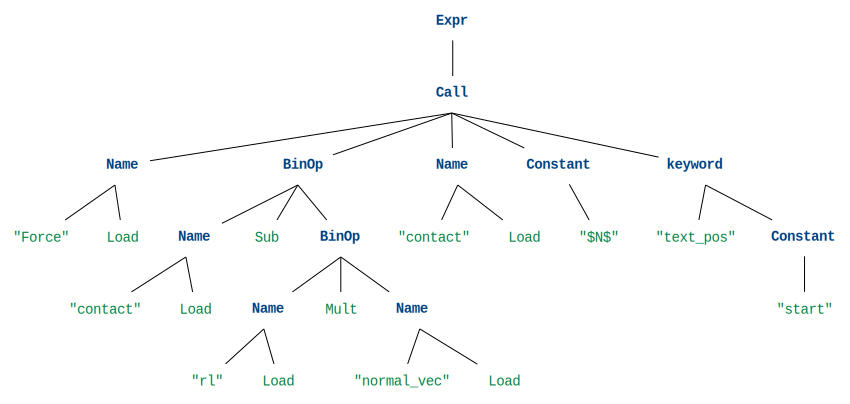

In [2]:
%%showast
Force(contact - rl*normal_vec, contact, r'$N$', text_pos='start')

In [16]:
import ast

root = ast.parse("Force(contact - rl*normal_vec, contact, r'$N$', text_pos='start')")
names = sorted({node.id for node in ast.walk(root) if isinstance(node, ast.Name)})
constants = sorted({node.value for node in ast.walk(root) if isinstance(node, ast.Constant)})

In [4]:
names

['Force', 'contact', 'normal_vec', 'rl']

In [17]:
constants

['$N$', 'start']

In [24]:
head = """\
libraries: ["from math import tan, radians, sin, cos","from pysketcher import *"]
fontsize: 18
g: 9.81              # constant gravity
theta: 30.0          # inclined plane angle
L: 10.0              # sketch sizing parameter
a: 1.0               #
xmin: 0.0            # sketech min Abscissa
ymin: -3.0           # sketech min Ordinate     
rl: 2.0              # rectangle width
rL: 1.0              # rectangle length
setframe:            # sketch setup
    action: "drawing_tool.set_coordinate_system(xmin=xmin-L/5, xmax=xmin+1.5*L,ymin=ymin, ymax=ymin+1.5*L,instruction_file='tmp_mpl_friction.py')"
setblackline:        # default frame values and actions
    action: "drawing_tool.set_linecolor('black')"
B: point(a+L,0)                      # wall right end
A: point(a,tan(radians(theta))*L)    # wall left end
normal_vec: point(sin(radians(theta)),cos(radians(theta)))     # Vector normal to wall
tangent_vec: point(cos(radians(theta)),-sin(radians(theta)))   # Vector tangent to wall
help_line: Line(A,B)                 # wall line
x: a + 3*L/10.
y: help_line(x=x)    
contact: point(x, y)    
c: contact + rL/2*normal_vec
"""

In [25]:
myfig={}

In [27]:
from pysketcher import *

In [28]:
sketchParse(head,myfig)

In [31]:
'g' in myfig

True